In [1]:
import cell2cell as c2c
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mlp

from tqdm.auto import tqdm
from statsmodels.stats.multitest import multipletests

%matplotlib inline

/Users/earmingol/opt/anaconda3/envs/c2c_dev/lib/python3.7/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt


# Analysis Setup

Here, all inputs and parameters needed for the analysis are defined

**Location of files**

In [2]:
data_folder = '../Data/'

In [3]:
files = dict()
files['rnaseq'] = data_folder + '/RNA-Seq/Celegans_RNASeqData_Cell.xlsx'
files['metadata'] = data_folder + '/RNA-Seq/Celegans_cell_metadata.tsv'
files['ppi'] = data_folder + '/PPI-Networks/Celegans-Curated-LR-pairs.xlsx'
files['ga_ppi'] = data_folder + '/PPI-Networks/Celegans-GA-Selected-LR-pairs.csv'
files['3d_atlas'] = data_folder + '/Digital-3D-Map/Celegans_Physical_Distances_Min.csv'
files['output_folder'] = '../Figures/'

# Load Data

**RNA-seq data manipulation**

- <font color="green">'gene_col'</font> is the name of the column containing the list or names of genes in the dataset.
- <font color="green">'drop_nangenes'</font> is a boolean decision to remove genes with NaN values.
- <font color="green">'log_transform'</font> is a boolean decision to log-transform the dataset.

In [4]:
rnaseq_setup = dict()
rnaseq_setup['gene_col'] = 'gene_id'
rnaseq_setup['drop_nangenes'] = True
rnaseq_setup['log_transform'] = False

**Metadata columns**

- <font color="green">'sample_col'</font> is the name of the column containing the sample or cell names in RNA-seq data (equivalent to the columns in rnaseq_data).
- <font color="green">'group_col'</font> is the name of the column containing the labels for the respective samples or cells in order to group/color them in downstream analyses.

In [5]:
meta_setup = dict()
meta_setup['sample_col'] = '#SampleID'
meta_setup['group_col'] = 'Groups'

**Columns for PPI network**

- <font color="green">'protein_cols'</font> is a list containing the names of the first and second interactors.

In [6]:
ppi_setup = dict()
ppi_setup['protein_cols'] = ['Ligand_WB', 'Receptor_WB']

**Cutoffs setup for binarizing gene expression**

- <font color="green">'type'</font> is the type of cutoff to use. 
    - 'constant_value'
    - 'local_percentile'
    - 'global_percentile'
    - None
- <font color="green">'parameter'</font> is the corresponding parameter for the type of cutoff. If percentile is used, it should be a value between 0 and 1. E.g. a value of 0.75 represents the 75-th percentile, and the cutoff to binarize the gene expression will be that value.

In [7]:
cutoff_setup = dict()
cutoff_setup['type'] = 'constant_value'
cutoff_setup['parameter'] = 10 # TPM

**General Analysis setups**

- <font color="green">'communication_score'</font> is the type of communication score used to detect active pathways between each pair of cell. It can be:
    - 'expression_thresholding'
    - 'expression_product'
    - 'expression_correlation'
    - 'differential_combinations'
- <font color="green">'cci_score'</font> is the scoring function to aggregate the communication scores. It can be:
    - 'bray_curtis'
    - 'jaccard'
    - 'count'
- <font color="green">'cci_type'</font> is the type of interaction between two cells. If it is undirected, ligand and receptor are considered from both cells. If it is directed, ligands from one cell and receptors from the other are considered separately with respect to ligands from the second cell and receptor from the first one. So, it can be:
    - 'undirected'
    - 'directed

In [8]:
analysis_setup = dict()
analysis_setup['communication_score'] = 'expression_thresholding'
analysis_setup['cci_score'] = 'bray_curtis'
analysis_setup['cci_type'] = 'undirected'

**RNA-seq**

In [9]:
rnaseq_data = c2c.io.load_rnaseq(rnaseq_file=files['rnaseq'],
                                 gene_column=rnaseq_setup['gene_col'],
                                 drop_nangenes=rnaseq_setup['drop_nangenes'],
                                 log_transformation=rnaseq_setup['log_transform'],
                                 format='auto')

Opening RNAseq datasets from ../Data//RNA-Seq/Celegans_RNASeqData_Cell.xlsx
../Data//RNA-Seq/Celegans_RNASeqData_Cell.xlsx was correctly loaded


**Metadata for cell types**

In [10]:
meta = c2c.io.load_metadata(metadata_file=files['metadata'],
                            rnaseq_data=rnaseq_data,
                            sample_col=meta_setup['sample_col'],
                            format='auto')

../Data//RNA-Seq/Celegans_cell_metadata.tsv was correctly loaded


**PPI network**

In [11]:
original_ppi_data = pd.read_excel(files['ppi'])

In [12]:
ga_ppi_data = pd.read_csv(files['ga_ppi'])

**Physical Location of cells**

In [13]:
physical_distance = c2c.io.load_table(files['3d_atlas'],
                                      **{'index_col' : 0})

../Data//Digital-3D-Map/Celegans_Physical_Distances_Min.csv was correctly loaded


**Cell-cell communication**

In [14]:
ccc_data = pd.read_csv('../Figures/CCC-Celegans-CuratedLR.csv', index_col=0)
ccc_data2 = pd.read_csv('../Figures/CCC-Celegans-SelectedLR.csv', index_col=0)

**Colors for ratios of GA selection across runs**

In [15]:
ga_colors = pd.read_csv('../Data/PPI-Networks/Celegans-GA-Run-Ratios-Color.csv', index_col=0)

In [16]:
ga_colors['Color'] = ga_colors['Color'].apply(lambda x: x.lstrip('(').rstrip(')').split(','))
ga_colors['Color'] = ga_colors['Color'].apply(lambda x: tuple([float(n) for n in x]))

In [17]:
ga_colors

,Color
arf-1.2 / pld-1,"(0.9969498910675382, 0.8684095860566449, 0.499..."
daf-7 / sma-6,"(0.996078431372549, 0.7490196078431373, 0.3529..."
srp-6 / F14B4.1,"(1.0, 1.0, 0.8, 1.0)"
adm-2 / pat-3,"(1.0, 1.0, 0.8, 1.0)"
adm-2 / pat-2,"(1.0, 1.0, 0.8, 1.0)"
...,...
mec-5 / mec-10,"(0.8570806100217866, 0.07930283224400879, 0.11..."
mec-9 / mec-10,"(1.0, 1.0, 0.8, 1.0)"
shn-1 / ced-1,"(1.0, 1.0, 0.8, 1.0)"
col-119 / daf-4,"(0.9969498910675382, 0.8684095860566449, 0.499..."


In [18]:
ga_ratios = pd.read_csv('../Data/PPI-Networks/Celegans-GA-Run-Ratios.csv', index_col=0)

# Run Analysis

## Colors

**Groups of cell types**

In [19]:
# Colors from figure S14 in C elegans paper (cell type expression data)
lut = {'Coelomocytes': (0.6509803921568628, 0.33725490196078434, 0.1568627450980392), # Brown
       'Neurons': (0.596078431372549, 0.3058823529411765, 0.6392156862745098), # Purple
       'Hypodermal/rectal cells': (0.30196078431372547, 0.6862745098039216, 0.2901960784313726), # Green
       'Pharyngeal cells': (0.21568627450980393, 0.49411764705882355, 0.7215686274509804), # Blue
       'Intestine': (1.0, 1.0, 0.2), # Yellow
       'Body/muscular cells': (0.8941176470588236, 0.10196078431372549, 0.10980392156862745), # Red
       'Excretory/Socket/Sheath cells': (1.0, 0.4980392156862745, 0.0), # Orange
       'Sexual cells': (0.9686274509803922, 0.5058823529411764, 0.7490196078431373)} # Pink

**LR functions**

In [20]:
#functions = original_ppi_data['LR Function'].unique()
functions = ['Cell migration', 'Wnt signaling', 'Cell adhesion', 'Notch signaling',
       'Insulin signaling', 'TGF-B signaling', 'Hedgehog signaling',
       'Mechanosensory mechanism', 'Canonical RTK-Ras-ERK signaling',
       'Neuronal communication', 'Eph receptor signaling',
       'Epidermal development', 'Lipid homeostasis', 'Immune response',
       'Trypsin-like proteolysis', 'Longevity', 'PCP pathway',
       'Receptor-Mediated-Endocytosis', 'Stress response', 'Apoptosis']

In [21]:
function_colors = c2c.utils.get_colors_from_labels(functions, cmap='tab20')

In [22]:
func_color_dict = dict()
row_cols = []
row_functions = []
for idx, row in original_ppi_data.iterrows():
    name = str(row['Ligand_symbol']) + ' / ' + str(row['Receptor_symbol'])
    func = str(row['LR Function'])
    func_color_dict[name] = function_colors[func]
    row_cols.append((name, function_colors[func]))
    row_functions.append((name, func))
row_cols = pd.DataFrame.from_records(row_cols, columns=['LR', 'Function']).set_index('LR')
row_functions = pd.DataFrame.from_records(row_functions, columns=['LR', 'Function']).set_index('LR')

In [23]:
row_cols

,Function
LR,
arf-1.2 / pld-1,"(1.0, 0.4980392156862745, 0.054901960784313725..."
daf-7 / sma-6,"(0.596078431372549, 0.8745098039215686, 0.5411..."
srp-6 / F14B4.1,"(0.6823529411764706, 0.7803921568627451, 0.909..."
adm-2 / pat-3,"(1.0, 0.4980392156862745, 0.054901960784313725..."
adm-2 / pat-2,"(1.0, 0.4980392156862745, 0.054901960784313725..."
...,...
mec-5 / mec-10,"(1.0, 0.596078431372549, 0.5882352941176471, 1.0)"
mec-9 / mec-10,"(1.0, 0.596078431372549, 0.5882352941176471, 1.0)"
shn-1 / ced-1,"(0.6196078431372549, 0.8549019607843137, 0.898..."


In [24]:
len(func_color_dict)

245

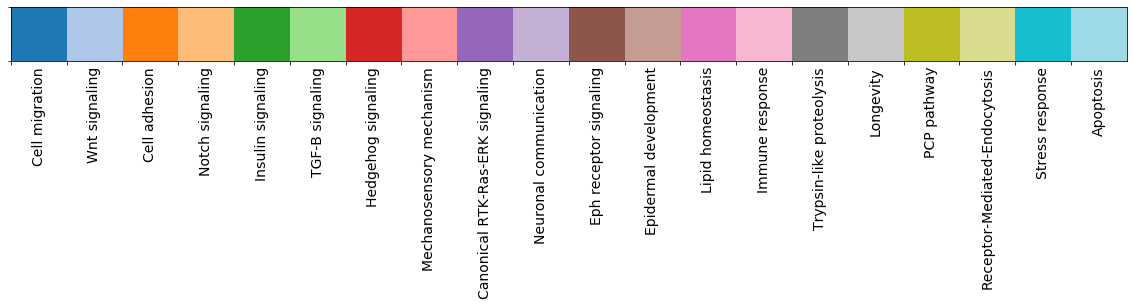

In [25]:
ax = sns.palplot(function_colors.values())
for i, text in enumerate(function_colors.keys()):
    plt.text(i, 0.6, text, rotation=90, horizontalalignment='center', verticalalignment='top',fontsize=14)

## Distances

In [26]:
distances = pd.melt(physical_distance.reset_index(), id_vars='index')

In [27]:
distances.shape

(484, 3)

In [28]:
def define_range(x):
    if x < 5.6:
        return 'short'
    elif x < 70.:
        return 'mid'
    else:
        return 'long'

In [29]:
distances['Range'] = distances['value'].apply(define_range)

In [30]:
distances['Interaction'] = distances.apply(lambda row: row['index']+';'+row['variable'], axis=1)

In [31]:
distances.head()

,index,variable,value,Range,Interaction
0,Am/PH_sheath_cells,Am/PH_sheath_cells,0.000000,short,Am/PH_sheath_cells;Am/PH_sheath_cells
1,Touch_receptor_neurons,Am/PH_sheath_cells,3.165871,short,Touch_receptor_neurons;Am/PH_sheath_cells
2,Oxygen_sensory_neurons,Am/PH_sheath_cells,1.809980,short,Oxygen_sensory_neurons;Am/PH_sheath_cells
3,GABAergic_neurons,Am/PH_sheath_cells,2.386306,short,GABAergic_neurons;Am/PH_sheath_cells
4,Rectum,Am/PH_sheath_cells,4.472614,short,Rectum;Am/PH_sheath_cells


Interaction space detected as a communication matrix


/Users/earmingol/Dropbox/Universidad/UCSanDiego/Lab_Lewis/cell2cell/cell2cell/utils/plotting.py:345: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  row_linkage = hc.linkage(dm_rows, method=method, optimal_ordering=optimal_leaf)
/Users/earmingol/Dropbox/Universidad/UCSanDiego/Lab_Lewis/cell2cell/cell2cell/utils/plotting.py:348: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  col_linkage = hc.linkage(dm_cols, method=method, optimal_ordering=optimal_leaf)


Interaction space detected as a communication matrix
Interaction space detected as a communication matrix


<Figure size 432x288 with 0 Axes>

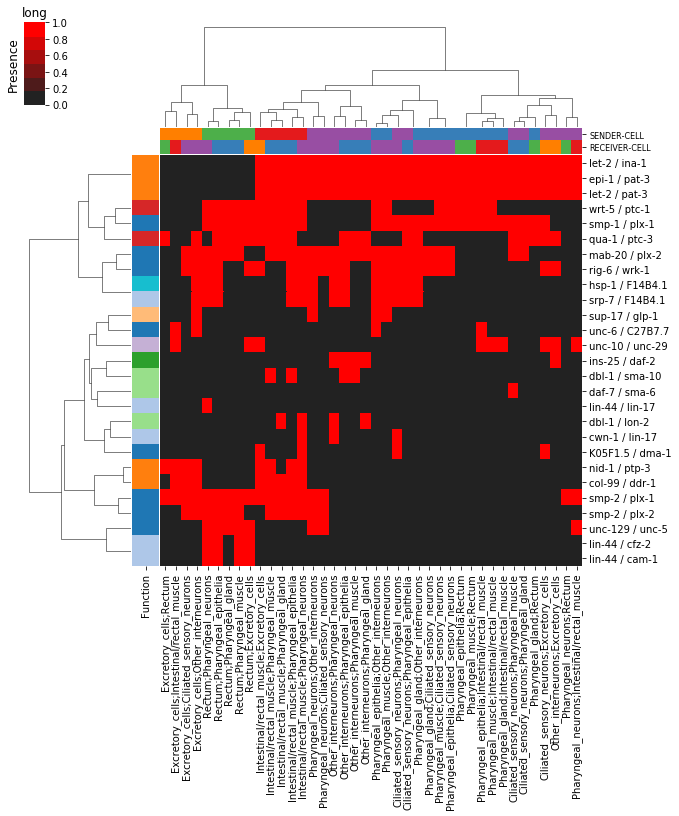

<Figure size 432x288 with 0 Axes>

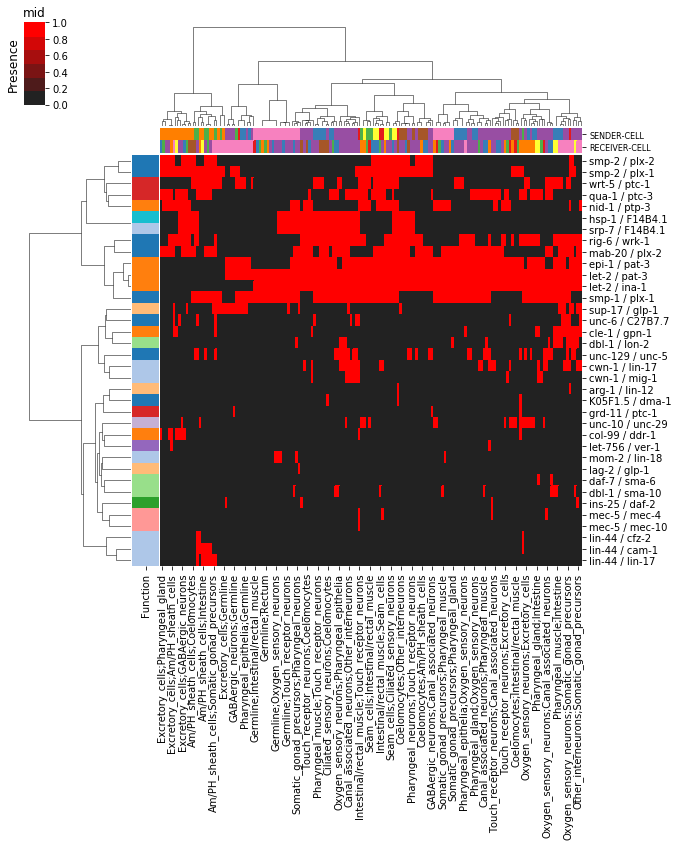

<Figure size 432x288 with 0 Axes>

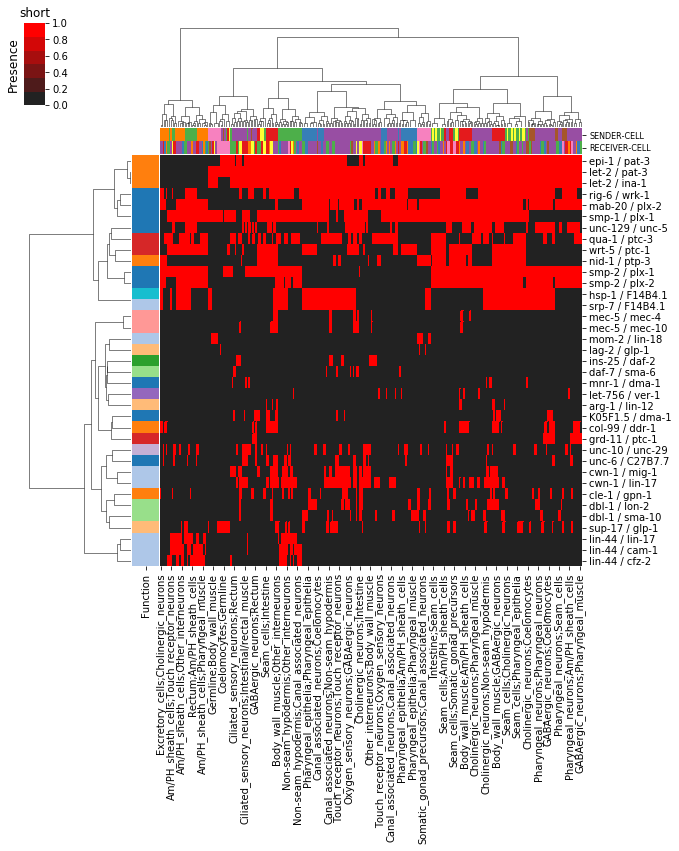

In [32]:
for r, df in distances.groupby('Range'):
    interactions = df['Interaction'].values.tolist()
    plt.figure()
    c2c.utils.clustermap_ccc(ccc_data2[interactions],
                             metadata=meta,
                             colors=lut,
                             **{'row_cluster' : True,
                                'row_colors' : row_cols['Function'],
                               }
                            )
    plt.title(r)

In [33]:
lr_per_range = pd.DataFrame(index=ccc_data.index, columns=['short', 'mid', 'long'])

total_interactions = dict()
for r, df in distances.groupby('Range'):
    interactions = df['Interaction'].values.tolist()
    val = ccc_data[interactions].sum(axis=1) / len(interactions)
    lr_per_range[r] = val
    print(r, len(interactions))
    total_interactions[r] = len(interactions)

long 40
mid 162
short 282


**Enrichment analysis**

In [34]:
active_lr_per_range = lr_per_range.copy()
for c in active_lr_per_range.columns:
    active_lr_per_range[c] = active_lr_per_range[c].apply(lambda x: total_interactions[c]*x)

enrich_per_range = active_lr_per_range.copy()
deplet_per_range = active_lr_per_range.copy()

In [35]:
N_active = active_lr_per_range.sum(axis=1).astype(int)
N = sum([v for v in total_interactions.values()])

for idx, row in active_lr_per_range.iterrows():
    for c in enrich_per_range.columns:
        def row_fn(row):
            return c2c.stats.hypergeom_representation(total_interactions[c],
                                                      row[c],
                                                      N,
                                                      N_active[idx])

        enrich_per_range.at[idx, c] = row_fn(row)[1]
        deplet_per_range.at[idx, c] = row_fn(row)[0]

**FDR correction**

In [36]:
fdr = 0.01

In [37]:
adj_enrich = c2c.stats.compute_fdrcorrection_asymmetric_matrix(enrich_per_range, alpha=fdr)
adj_deplet = c2c.stats.compute_fdrcorrection_asymmetric_matrix(deplet_per_range, alpha=fdr)

**Visualization**

In [38]:
adj_both = adj_enrich.lt(fdr).astype(int)-1*adj_deplet.lt(fdr).astype(int)

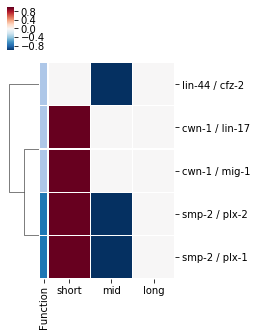

In [39]:
X = adj_both.loc[ccc_data2.index,:]
X = X[(X.T != 0).any()]
cm_ed = sns.clustermap(X,
                       cmap='RdBu_r',
                       col_cluster=False,
                       metric='jaccard',
                       method='complete',
                       linewidths=.2,
                       row_colors=row_cols['Function'],
                       #row_linkage=linkage,
                       #row_colors=ga_colors.loc[ccc_data2.index,:],
                       **{'figsize' : (3,5),
                          #'annot' : True
                         }
                       )